## **Strassen's Algorithm: Overview and Applications**

### Mohara de Oliveira Nascimento


### **Table of contents**

1. [Importing libraries](#1.-Importing-libraries)
2. [Matrix Multiplication Algorithms](#2.-Matrix-Multiplication-Algorithms)

    2.1 [Naive algorithm](#21-Naive-algorithm)

    2.2 [Strassen's algorithm](#22-Strassen's-algorithm)

3. [Comparative study](#3-comparative-study)

    3.1 [Small matrices](#31-small-matrices)

    3.2 [Large matrices](#32-large-matrices)

    3.3 [Any dimension matrices](#33-any-dimension-matrices)

    3.4 [Numerical difference between the methods](#34-Numerical-difference-between-the-methods)

    3.5 [Stability of the methods](#35-stability-of-the-methods)

## **[1. Importing libraries](#1-Importing-libraries)** 

In [1]:
# Importing necessary libraries
import numpy as np
import scipy as scp
from scipy.interpolate import make_interp_spline, BSpline
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
from timeit import default_timer as timer
from tabulate import tabulate

## **[2. Matrix Multiplication Algorithms](#2.-Matrix-Multiplication-Algorithms)** 

#### **[2.1 Naive algorithm](#21-naive-algorithm)**

The following code was taken from the Notebook: "Notebook para decomposição LU e forma escalonada" available in the Materials of the 2024 Linear Algebra and Applications course accessed via the link: https://w3.impa.br/~jpereira

In [2]:
# Function for manual matrix multiplication
def manual_matrix_multiplication(A, B):
    m, n = A.shape
    n_, p = B.shape
    
    if n != n_:
        print("Incompatible matrices. Can't perform multiplication.")
        return
    
    # Create the result matrix and fill it with zeros
    result = np.zeros((m, p))

    # Performing matrix multiplication
    for i in range(m): # iterate over rows
        for j in range(p): # iterate over columns
            for k in range(n): # summing over all k
                result[i, j] += A[i, k] * B[k, j]
    
    return result


#### **[2.2 Strassen's algorithm](#22-strassens-algorithm)**

The following code was adapted from the reference: https://www.geeksforgeeks.org/strassens-matrix-multiplication/

In [3]:
# Function for divide a matrix M (nxn) in 4 submatrix (n/2 x n/2)
def divide(M):
    row, col = M.shape
    row2,col2 = row//2, col//2
    return M[:row2, :col2], M[:row2, col2:], M[row2:, :col2], M[row2:, col2:]

# Function to insert the final elements in the rows and columns
def combine_matrices(C11, C12, C21, C22):
    top = np.concatenate((C11, C12), axis=1)
    bottom = np.concatenate((C21, C22), axis=1)
    return np.concatenate((top, bottom), axis=0)

In [4]:

# Function for strassen matrix multiplication
def strassen_matrix_multiplication(A, B):
	"""
	Computes matrix product by divide and conquer approach, recursively.
	Input: nxn matrices A and B
	Output: nxn matrix, product of A and B
	"""

	# Base case when size of matrices is 1x1
	if len(A) == 1:
		return A * B

	# Splitting the matrices into quadrants. This will be done recursively
	# until the base case is reached.
	a, b, c, d = divide(A)
	e, f, g, h = divide(B)

	# Computing the 7 products, recursively (p1, p2...p7)
	p1 = strassen_matrix_multiplication(a, f - h) 
	p2 = strassen_matrix_multiplication(a + b, h)	 
	p3 = strassen_matrix_multiplication(c + d, e)	 
	p4 = strassen_matrix_multiplication(d, g - e)	 
	p5 = strassen_matrix_multiplication(a + d, e + h)	 
	p6 = strassen_matrix_multiplication(b - d, g + h) 
	p7 = strassen_matrix_multiplication(a - c, e + f) 

	# Computing the values of the 4 quadrants of the final matrix c
	c11 = p5 + p4 - p2 + p6 
	c12 = p1 + p2		 
	c21 = p3 + p4		 
	c22 = p1 + p5 - p3 - p7 

	# Combining the 4 quadrants into a single matrix by stacking horizontally and vertically.
	C = combine_matrices(c11, c12, c21, c22)

	return C

## **[3. Comparative study](#3.-Comparative-study)** 

#### **[3.1 Small matrices](#31-small-matrices)**

Initialy was perfomed some test with the standart Strassen algorithm to analyze its perfomance to small dimension matrices.

In [18]:
def size_time(method,n):
    # Time and run the determinant function
    rng = np.random.default_rng(seed=42) # set a seed for matrices being the same for all the algorithms
    A = rng.random((n, n))
    B = rng.random((n, n))

    start_time = timer()
    mult = method(A,B)
    end_time = timer()
    return end_time - start_time

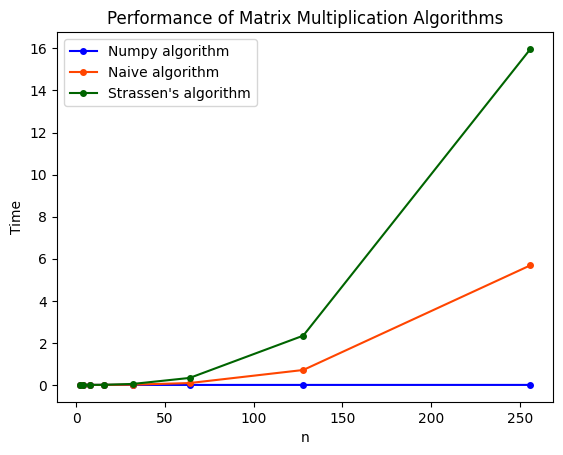

In [40]:
group_n = [1, 2, 3, 4, 5, 6, 7, 8]
ns = [2**n for n in group_n]

x = [n for n in ns]

y1 = [size_time(np.dot,n) for n in ns] 
plt.plot(x, y1, label="Numpy algorithm", linestyle='-', color='Blue',marker='o', markersize=4) 

y2 = [size_time(manual_matrix_multiplication,n) for n in ns] 
plt.plot(x, y2, label="Naive algorithm", linestyle='-', marker='o', color='OrangeRed', markersize=4) 

y3 = [size_time(strassen_matrix_multiplication,n) for n in ns] 
plt.plot(x,y3, label="Strassen's algorithm", color='DarkGreen',linestyle='-', markersize=4, marker='o')
  
plt.xlabel("n") 
plt.ylabel("Time") 
plt.title('Performance of Matrix Multiplication Algorithms') 
plt.legend()
plt.show() 

The code below is made to smoothing the graph, since the function are of order O(n^3) e O(n^2.8).

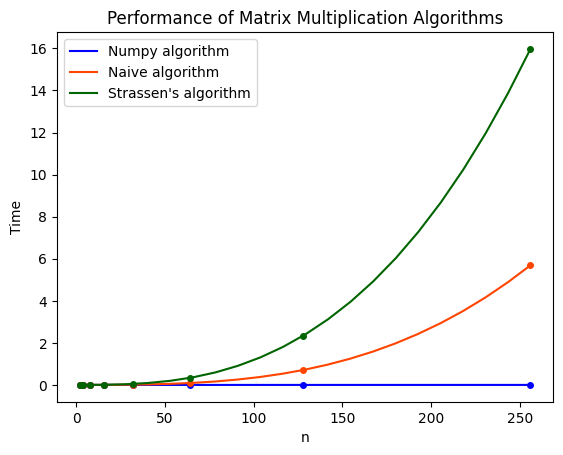

In [41]:
# Adapting the graphic, building interpolated splines to represent the cubic/almost cubic funcions
tck1, u1 = interpolate.splprep([x,y1],s=0)
unew1 = np.arange(0,1.05,0.05)
out1 = interpolate.splev(unew1,tck1)
plt.plot(x, y1, linestyle='None', color='Blue',marker='o', markersize=4) 
plt.plot(out1[0], out1[1], label="Numpy algorithm", linestyle='-',  color='Blue', markersize=4) 

tck2, u2 = interpolate.splprep([x,y2],s=0)
unew2 = np.arange(0,1.05,0.05)
out2 = interpolate.splev(unew2,tck2)
plt.plot(x, y2, linestyle='None', marker='o', color='OrangeRed', markersize=4) 
plt.plot(out2[0], out2[1], label="Naive algorithm", linestyle='-', color='OrangeRed', markersize=4) 

tck, u = interpolate.splprep([x,y3],s=0)
unew = np.arange(0,1.05,0.05)
out = interpolate.splev(unew,tck)
plt.plot(x,y3, color='DarkGreen',linestyle='None', markersize=4, marker='o')
plt.plot(out[0],out[1], label="Strassen's algorithm", linestyle='-', color='DarkGreen', markersize=4) 
  
plt.xlabel("n") 
plt.ylabel("Time") 
plt.title('Performance of Matrix Multiplication Algorithms') 
plt.legend()
plt.show() 

This datas also are shown in the table below:

In [42]:
# Creating a table with comparative data n x time
table_title = ['Method'] + [f'n = {n}' for n in x]
line1 = ['Numpy'] + [f'{round(n,10)}s' for n in y1]
line2 = ['Naive'] + [f'{round(n,10)}s' for n in y2]
line3 = ['Strassen'] + [f'{round(n,10)}s' for n in y3]
table_contend = [table_title, line1, line2, line3]

print(tabulate(table_contend, headers= 'firstrow', tablefmt='fancy_grid'))

╒══════════╤═══════════╤════════════╤════════════╤════════════╤════════════╤════════════╤════════════╤═════════════╕
│ Method   │ n = 2     │ n = 4      │ n = 8      │ n = 16     │ n = 32     │ n = 64     │ n = 128    │ n = 256     │
╞══════════╪═══════════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪═════════════╡
│ Numpy    │ 6.87e-05s │ 3.7e-06s   │ 3.1e-06s   │ 2.3e-06s   │ 5.7e-06s   │ 2.71e-05s  │ 0.0001213s │ 0.000507s   │
├──────────┼───────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼─────────────┤
│ Naive    │ 7.3e-06s  │ 2.76e-05s  │ 0.0001922s │ 0.0014854s │ 0.0120856s │ 0.0891348s │ 0.7098158s │ 5.6886625s  │
├──────────┼───────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼─────────────┤
│ Strassen │ 3.43e-05s │ 0.0001483s │ 0.0009676s │ 0.0067924s │ 0.0470991s │ 0.3324375s │ 2.3427909s │ 15.9754242s │
╘══════════╧═══════════╧════════════╧════════════╧════════════╧═

#### **[3.2 Large matrices](#32-large-matrices)**

For large matrices is essential tp optmize the Strassen's algorithm, introducing a hybrid implementation that considers a crossover point, responsable for switch from Strassen's to naive method in small block matrices of order less than crossover point. According with references, this point must be 64, 100 or 32, so in these tests will be used a crossover point of 64 and another of 32.

- #### Strassen's optimized algorithm

This section is destined to apply a techinique to optimize the Strassen's standart algorithm. First with a crossover point of 64 and then of 32.

**Strassen's optimized algorithm with crossover point of 64:**

In [37]:
# Function for strassen matrix multiplication
def strassen_optimized(A, B, crossover_point=64):
	"""
	Computes matrix product by divide and conquer approach, recursively. However, in small matrices uses the Naive Method.
	"""

	# Base case when size of matrices is 1x1
	if len(A) == 1:
		return A * B
    
	n = len(A)
	if n<=crossover_point:
		return manual_matrix_multiplication(A,B)
	else:
		# Splitting the matrices into quadrants. This will be done recursively
		# until the base case is reached.
		a, b, c, d = divide(A)
		e, f, g, h = divide(B)
	

		# Computing the 7 products, recursively (p1, p2...p7)
		p1 = strassen_optimized(a, f - h, crossover_point) 
		p2 = strassen_optimized(a + b, h, crossover_point)	 
		p3 = strassen_optimized(c + d, e, crossover_point)	 
		p4 = strassen_optimized(d, g - e, crossover_point)	 
		p5 = strassen_optimized(a + d, e + h, crossover_point)	 
		p6 = strassen_optimized(b - d, g + h, crossover_point) 
		p7 = strassen_optimized(a - c, e + f, crossover_point) 

		# Computing the values of the 4 quadrants of the final matrix c
		c11 = p5 + p4 - p2 + p6 
		c12 = p1 + p2		 
		c21 = p3 + p4		 
		c22 = p1 + p5 - p3 - p7 

		# Combining the 4 quadrants into a single matrix by stacking horizontally and vertically.
		C = combine_matrices(c11, c12, c21, c22)

		return C

Strassen's optimized algorithm tests fo matrix 2^n x 2^n, with n between 1 and 11.

In [ ]:
group_n = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
ns = [2**n for n in group_n]

x = [n for n in ns]

y1 = [size_time(np.dot,n) for n in ns] 
tck1, u1 = interpolate.splprep([x,y1],s=0)
unew1 = np.arange(0,1.05,0.05)
out1 = interpolate.splev(unew1,tck1)

y2 = [size_time(manual_matrix_multiplication,n) for n in ns] 
tck2, u2 = interpolate.splprep([x,y2],s=0)
unew2 = np.arange(0,1.05,0.05)
out2 = interpolate.splev(unew2,tck2)

y3 = [size_time(strassen_optimized,n) for n in ns] 
tck3, u3 = interpolate.splprep([x,y3],s=0)
unew3 = np.arange(0,1.05,0.05)
out3 = interpolate.splev(unew3,tck3) 

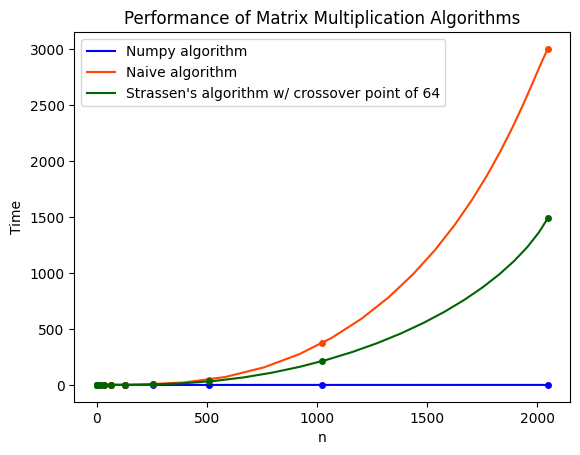

In [46]:
plt.plot(x, y1, linestyle='None', color='Blue',marker='o', markersize=4) 
plt.plot(out1[0], out1[1], label="Numpy algorithm", linestyle='-',  color='Blue', markersize=4) 

plt.plot(x, y2, linestyle='None', marker='o', color='OrangeRed', markersize=4) 
plt.plot(out2[0], out2[1], label="Naive algorithm", linestyle='-',  color='OrangeRed', markersize=4) 

plt.plot(x,y3, color='DarkGreen',linestyle='None', markersize=4, marker='o')
plt.plot(out3[0], out3[1], label="Strassen's algorithm w/ crossover point of 64", linestyle='-',  color='DarkGreen', markersize=4) 

plt.xlabel("n") 
plt.ylabel("Time") 
plt.title('Performance of Matrix Multiplication Algorithms') 
plt.legend()
plt.show()  

In [45]:
# Table with comparative datas n x time
table_title = ['Method'] + [f'n = {n}' for n in x]
line1 = ['Numpy'] + [f'{round(n,10)}s' for n in y1]
line2 = ['Naive'] + [f'{round(n,10)}s' for n in y2]
line3 = ['Strassen'] + [f'{round(n,10)}s' for n in y3]
table_contend = [table_title, line1, line2, line3]

print(tabulate(table_contend, headers= 'firstrow', tablefmt='fancy_grid'))

╒══════════╤═══════════╤═══════════╤════════════╤════════════╤════════════╤════════════╤════════════╤════════════╤═════════════╤══════════════╤═══════════════╕
│ Method   │ n = 2     │ n = 4     │ n = 8      │ n = 16     │ n = 32     │ n = 64     │ n = 128    │ n = 256    │ n = 512     │ n = 1024     │ n = 2048      │
╞══════════╪═══════════╪═══════════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪═════════════╪══════════════╪═══════════════╡
│ Numpy    │ 5.61e-05s │ 2.79e-05s │ 1.5e-05s   │ 6.78e-05s  │ 1.07e-05s  │ 2.14e-05s  │ 0.0001599s │ 0.0003916s │ 0.0019479s  │ 0.0140993s   │ 0.0699031s    │
├──────────┼───────────┼───────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼─────────────┼──────────────┼───────────────┤
│ Naive    │ 7.4e-06s  │ 2.79e-05s │ 0.0001919s │ 0.0014831s │ 0.0113242s │ 0.0886996s │ 0.7278934s │ 5.6835419s │ 47.1526083s │ 373.4997032s │ 3001.7311135s │
├──────────┼───────────┼───────────┼────

**Strassen's optimized algorithm with crossover point of 32:**

In [20]:
# Function for strassen matrix multiplication
def strassen_optimized_32(A, B, crossover_point=32):
	"""
	Computes matrix product by divide and conquer approach, recursively. However, in small matrices uses the Naive Method.
	"""

	# Base case when size of matrices is 1x1
	if len(A) == 1:
		return A * B
    
	n = len(A)
	if n<=crossover_point:
		return manual_matrix_multiplication(A,B)
	else:
		# Splitting the matrices into quadrants. This will be done recursively
		# until the base case is reached.
		a, b, c, d = divide(A)
		e, f, g, h = divide(B)
	

		# Computing the 7 products, recursively (p1, p2...p7)
		p1 = strassen_optimized_32(a, f - h, crossover_point) 
		p2 = strassen_optimized_32(a + b, h, crossover_point)	 
		p3 = strassen_optimized_32(c + d, e, crossover_point)	 
		p4 = strassen_optimized_32(d, g - e, crossover_point)	 
		p5 = strassen_optimized_32(a + d, e + h, crossover_point)	 
		p6 = strassen_optimized_32(b - d, g + h, crossover_point) 
		p7 = strassen_optimized_32(a - c, e + f, crossover_point) 

		# Computing the values of the 4 quadrants of the final matrix c
		c11 = p5 + p4 - p2 + p6 
		c12 = p1 + p2		 
		c21 = p3 + p4		 
		c22 = p1 + p5 - p3 - p7 

		# Combining the 4 quadrants into a single matrix by stacking horizontally and vertically.
		C = combine_matrices(c11, c12, c21, c22)

		return C

Strassen's optimized algorithm tests with crossover-point of 32.

In [48]:
group_n = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
ns = [2**n for n in group_n]

x = [n for n in ns]

y1 = [size_time(np.dot,n) for n in ns] 
tck1, u1 = interpolate.splprep([x,y1],s=0)
unew1 = np.arange(0,1.05,0.05)
out1 = interpolate.splev(unew1,tck1)

y2 = [size_time(manual_matrix_multiplication,n) for n in ns] 
tck2, u2 = interpolate.splprep([x,y2],s=0)
unew2 = np.arange(0,1.05,0.05)
out2 = interpolate.splev(unew2,tck2)

y3 = [size_time(strassen_optimized_32,n) for n in ns] 
tck3, u3 = interpolate.splprep([x,y3],s=0)
unew3 = np.arange(0,1.05,0.05)
out3 = interpolate.splev(unew3,tck3) 

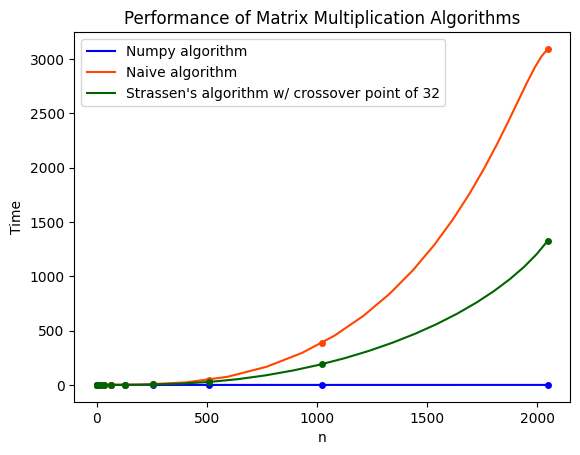

In [64]:
plt.plot(x, y1, linestyle='None', color='Blue',marker='o', markersize=4) 
plt.plot(out1[0], out1[1], label="Numpy algorithm", linestyle='-',  color='Blue', markersize=4) 

tck2, u2 = interpolate.splprep([x,y2],s=0)
unew2 = np.arange(0,1.05,0.05)
out2 = interpolate.splev(unew2,tck2)

plt.plot(x, y2, linestyle='None', marker='o', color='OrangeRed', markersize=4) 
plt.plot(out2[0], out2[1], label="Naive algorithm", linestyle='-',  color='OrangeRed', markersize=4) 

plt.plot(x,y3, color='DarkGreen',linestyle='None', markersize=4, marker='o')
plt.plot(out3[0], out3[1], label="Strassen's algorithm w/ crossover point of 32", linestyle='-',  color='DarkGreen', markersize=4) 

plt.xlabel("n") 
plt.ylabel("Time") 
plt.title('Performance of Matrix Multiplication Algorithms') 
plt.legend()
plt.show()  

In [65]:
# Table with comparative datas n x time
table_title = ['Method'] + [f'n = {n}' for n in x]
line1 = ['Numpy'] + [f'{round(n,10)}s' for n in y1]
line2 = ['Naive'] + [f'{round(n,10)}s' for n in y2]
line3 = ['Strassen'] + [f'{round(n,10)}s' for n in y3]
table_contend = [table_title, line1, line2, line3]

print(tabulate(table_contend, headers= 'firstrow', tablefmt='fancy_grid'))

╒══════════╤═══════════╤═══════════╤════════════╤════════════╤════════════╤════════════╤════════════╤════════════╤═════════════╤══════════════╤═══════════════╕
│ Method   │ n = 2     │ n = 4     │ n = 8      │ n = 16     │ n = 32     │ n = 64     │ n = 128    │ n = 256    │ n = 512     │ n = 1024     │ n = 2048      │
╞══════════╪═══════════╪═══════════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪═════════════╪══════════════╪═══════════════╡
│ Numpy    │ 6.91e-05s │ 8.54e-05s │ 3.2e-06s   │ 2.5e-06s   │ 6.6e-06s   │ 1.94e-05s  │ 0.0001966s │ 0.0003088s │ 0.0017754s  │ 0.0133656s   │ 0.0724675s    │
├──────────┼───────────┼───────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼─────────────┼──────────────┼───────────────┤
│ Naive    │ 9.9e-06s  │ 3.16e-05s │ 0.0002183s │ 0.0016752s │ 0.0122836s │ 0.0929303s │ 0.7221653s │ 5.7614862s │ 46.8814399s │ 388.1212362s │ 3093.0746955s │
├──────────┼───────────┼───────────┼────

#### **[3.3 Any dimension matrices](#33-any-dimension-matrices)**

For apply the Strassen's algorithm to any dimensions matrices it is necessary to do a padding of the original matrices to the form 2^n, filling the missing datas with zeros.

In [21]:
def pad_matrix(A):
    n = len(A)
    # Determine the next power of 2
    next_power_of_2 = 1 << (n - 1).bit_length()
    padded_A = np.zeros((next_power_of_2, next_power_of_2), dtype=A.dtype)
    padded_A[:n, :n] = A
    return padded_A

def strassen_optimized_padding(A, B, crossover_point=32):
	# Base case when size of matrices is 1x1
	if len(A) == 1:
		return A * B
    
	n = len(A)

	if n<=crossover_point:
		return manual_matrix_multiplication(A,B)
	else:
		A = pad_matrix(A)
		B = pad_matrix(B)

		# Splitting the matrices into quadrants. This will be done recursively
		# until the base case is reached.
		a, b, c, d = divide(A)
		e, f, g, h = divide(B)

		# Computing the 7 products, recursively (p1, p2...p7)
		p1 = strassen_optimized_padding(a, f - h, crossover_point) 
		p2 = strassen_optimized_padding(a + b, h, crossover_point)	 
		p3 = strassen_optimized_padding(c + d, e, crossover_point)	 
		p4 = strassen_optimized_padding(d, g - e, crossover_point)	 
		p5 = strassen_optimized_padding(a + d, e + h, crossover_point)	 
		p6 = strassen_optimized_padding(b - d, g + h, crossover_point) 
		p7 = strassen_optimized_padding(a - c, e + f, crossover_point) 

		# Computing the values of the 4 quadrants of the final matrix c
		c11 = p5 + p4 - p2 + p6 
		c12 = p1 + p2		 
		c21 = p3 + p4		 
		c22 = p1 + p5 - p3 - p7 

		# Combining the 4 quadrants into a single matrix by stacking horizontally and vertically.
		C = combine_matrices(c11, c12, c21, c22)

		return C

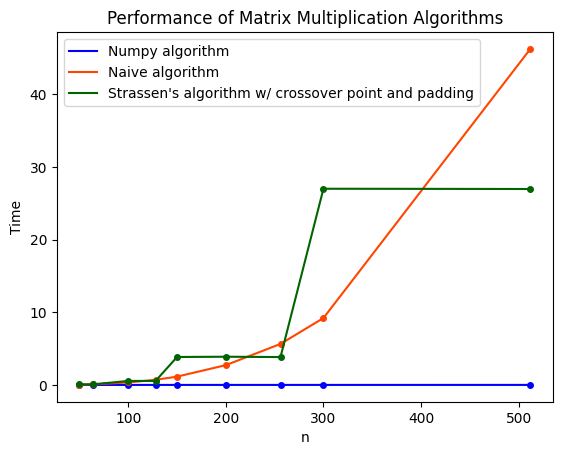

In [12]:
ns = [50,64,100,128,150,200,256,300,512]

x = [n for n in ns]

y1 = [size_time(np.dot,n) for n in ns] 
plt.plot(x, y1, linestyle='None', color='Blue',marker='o', markersize=4) 
o1 = x
o2 = y1
plt.plot(o1, o2, label="Numpy algorithm", linestyle='-',  color='Blue', markersize=4) 

y2 = [size_time(manual_matrix_multiplication,n) for n in ns] 
plt.plot(x, y2, linestyle='None', marker='o', color='OrangeRed', markersize=4)
plt.plot(x, y2, label="Naive algorithm", linestyle='-', color='OrangeRed', markersize=4) 

y3 = [size_time(strassen_optimized_padding,n) for n in ns] 
plt.plot(x, y3, linestyle='None', marker='o', color='DarkGreen', markersize=4)
plt.plot(x,y3, label="Strassen's algorithm w/ crossover point and padding", color='DarkGreen',linestyle='-', markersize=4)
  
plt.xlabel("n") 
plt.ylabel("Time") 
plt.title('Performance of Matrix Multiplication Algorithms') 
plt.legend()
plt.show() 

In [13]:
# Table with comparative datas n x time
table_title = ['Method'] + [f'n = {n}' for n in x]
line1 = ['Numpy'] + [f'{round(n,10)}s' for n in y1]
line2 = ['Naive'] + [f'{round(n,10)}s' for n in y2]
line3 = ['Strassen'] + [f'{round(n,10)}s' for n in y3]
table_contend = [table_title, line1, line2, line3]

print(tabulate(table_contend, headers= 'firstrow', tablefmt='fancy_grid'))

╒══════════╤════════════╤════════════╤════════════╤════════════╤════════════╤════════════╤════════════╤═════════════╤═════════════╕
│ Method   │ n = 50     │ n = 64     │ n = 100    │ n = 128    │ n = 150    │ n = 200    │ n = 256    │ n = 300     │ n = 512     │
╞══════════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪═════════════╪═════════════╡
│ Numpy    │ 2.1e-05s   │ 1.72e-05s  │ 0.0001011s │ 8.78e-05s  │ 0.0001058s │ 0.0001741s │ 0.0002966s │ 0.0005975s  │ 0.0017758s  │
├──────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼─────────────┼─────────────┤
│ Naive    │ 0.0445271s │ 0.0879027s │ 0.3357018s │ 0.7033277s │ 1.1410511s │ 2.7227818s │ 5.6395424s │ 9.2023742s  │ 46.2309341s │
├──────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼─────────────┼─────────────┤
│ Strassen │ 0.0777786s │ 0.0780959s │ 0.5487827s │ 0.5482522s │ 3.8430705s 

#### **[3.4 Numerical difference between the methods](#34-Numerical-difference-between-the-methods)**

In [23]:
def absolute_max_diference(method1,method2,n):
    # Time and run the determinant function
    rng = np.random.default_rng(seed=42) # set a seed for matrices being the same for all the algorithms
    A = np.random.rand(n, n)
    B = np.random.rand(n, n)

    mult1 = method1(A,B)
    mult2 = method2(A,B)

    return max(abs((mult1-mult2).min()), abs((mult1-mult2).max()))

In [23]:
group_n = [1, 2, 3, 4, 5, 6, 7, 8, 9]
ns = [2**n for n in group_n]

dif_naive_pure_strassen = [absolute_max_diference(manual_matrix_multiplication,strassen_matrix_multiplication,n) for n in ns]
dif_naive_strassen_64 = [absolute_max_diference(manual_matrix_multiplication,strassen_optimized,n) for n in ns]

# Table with comparative datas n x time
table_title = ['Method'] + [f'n = {n}' for n in ns]
line1 = ['Naive x Pure Strassen'] + [n for n in dif_naive_pure_strassen]
line2 = ['Naive x Strassen Optmized with crossover-point of 64'] + [n for n in dif_naive_strassen_64]
table_contend = [table_title, line1, line2]

print(tabulate(table_contend, headers= 'firstrow', tablefmt='fancy_grid'))

╒══════════════════════════════════════════════════════╤═════════════╤═════════════╤═════════════╤════════════╤═════════════╤═════════════╤═════════════╤═════════════╤═════════════╕
│ Method                                               │       n = 2 │       n = 4 │       n = 8 │     n = 16 │      n = 32 │      n = 64 │     n = 128 │     n = 256 │     n = 512 │
╞══════════════════════════════════════════════════════╪═════════════╪═════════════╪═════════════╪════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ Naive x Pure Strassen                                │ 3.33067e-16 │ 8.88178e-16 │ 2.22045e-15 │ 1.5099e-14 │ 2.25597e-13 │ 3.90799e-13 │ 3.1406e-12  │ 1.00897e-11 │ 6.91784e-11 │
├──────────────────────────────────────────────────────┼─────────────┼─────────────┼─────────────┼────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│ Naive x Strassen Optmized with crossover-point of 64 │ 0           │ 0           │ 0    

In [24]:
group_n = [5, 6, 7, 8, 9, 10]
ns = [2**n for n in group_n]

dif_naive_pure_strassen = [absolute_max_diference(manual_matrix_multiplication,strassen_matrix_multiplication,n) for n in ns]
dif_naive_strassen_64 = [absolute_max_diference(manual_matrix_multiplication,strassen_optimized,n) for n in ns]

# Table with comparative datas n x time
table_title = ['Method'] + [f'n = {n}' for n in ns]
line1 = ['Naive x Pure Strassen'] + [n for n in dif_naive_pure_strassen]
line2 = ['Naive x Strassen Optmized with crossover-point of 64'] + [n for n in dif_naive_strassen_64]
table_contend = [table_title, line1, line2]

print(tabulate(table_contend, headers= 'firstrow', tablefmt='fancy_grid'))

╒══════════════════════════════════════════════════════╤═════════════╤═════════════╤═════════════╤═════════════╤═════════════╤═════════════╕
│ Method                                               │      n = 32 │      n = 64 │     n = 128 │     n = 256 │     n = 512 │    n = 1024 │
╞══════════════════════════════════════════════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ Naive x Pure Strassen                                │ 6.57252e-14 │ 6.11067e-13 │ 2.48335e-12 │ 1.0175e-11  │ 5.66729e-11 │ 2.6921e-10  │
├──────────────────────────────────────────────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│ Naive x Strassen Optmized with crossover-point of 64 │ 0           │ 0           │ 8.52651e-14 │ 3.12639e-13 │ 1.36424e-12 │ 6.36646e-12 │
╘══════════════════════════════════════════════════════╧═════════════╧═════════════╧═════════════╧═════════════╧═════════════╧═════════════╛


#### **[3.5 Stability of the methods](#35-Stability-of-the-methods)**

In [28]:
print('Strassen w/ crossover point stability for random matrices')
C = np.random.rand(64, 64)
D = np.random.rand(128, 128)
E = np.random.rand(256, 256)
F = np.random.rand(512, 512)
G = np.random.rand(1024, 1024)
H = np.random.rand(2048, 2048)

id64 = np.identity(64)
id128 = np.identity(128)
id256 = np.identity(256)
id512 = np.identity(512)
id1024 = np.identity(1024)
id2048 = np.identity(2048)

error64 = max(abs((C-strassen_optimized(C,id64)).min()), abs((C-strassen_optimized(C,id64)).max()))
error128 =max(abs((D-strassen_optimized(D,id128)).min()), abs((D-strassen_optimized(D,id128)).max()))
error256 =max(abs((E-strassen_optimized(E,id256)).min()), abs((E-strassen_optimized(E,id256)).max()))
error512 =max(abs((F-strassen_optimized(F,id512)).min()), abs((F-strassen_optimized(F,id512)).max()))
error1024 =max(abs((G-strassen_optimized(G,id1024)).min()), abs((G-strassen_optimized(G,id1024)).max()))
error2048 =max(abs((H-strassen_optimized(H,id2048)).min()), abs((H-strassen_optimized(H,id2048)).max()))

errors = [error64, error128, error256, error512, error1024, error2048]

# Table with comparative datas n x time
n = [64, 128, 256, 512, 1024, 2048]
table_title = [''] + [f'n = {n}' for n in n]
line1 = ['Max error of: (Strassen w/ cp = 64) - (Strassen w/ cp = 64)*(Identity matrix)'] + [e for e in errors]
table_contend = [table_title, line1]

print(tabulate(table_contend, headers= 'firstrow', tablefmt='fancy_grid'))



Strassen w/ crossover point stability for random matrices
╒═══════════════════════════════════════════════════════════════════════════════╤══════════╤═════════════╤════════════╤═════════════╤═════════════╤═════════════╕
│                                                                               │   n = 64 │     n = 128 │    n = 256 │     n = 512 │    n = 1024 │    n = 2048 │
╞═══════════════════════════════════════════════════════════════════════════════╪══════════╪═════════════╪════════════╪═════════════╪═════════════╪═════════════╡
│ Max error of: (Strassen w/ cp = 64) - (Strassen w/ cp = 64)*(Identity matrix) │        0 │ 5.55112e-16 │ 2.9976e-15 │ 1.43219e-14 │ 6.83897e-14 │ 3.03091e-13 │
╘═══════════════════════════════════════════════════════════════════════════════╧══════════╧═════════════╧════════════╧═════════════╧═════════════╧═════════════╛


In [30]:
print('Strassen stability for random matrices')
C = np.random.rand(64, 64)
D = np.random.rand(128, 128)
E = np.random.rand(256, 256)
F = np.random.rand(512, 512)
G = np.random.rand(1024, 1024)

id64 = np.identity(64)
id128 = np.identity(128)
id256 = np.identity(256)
id512 = np.identity(512)
id1024 = np.identity(1024)

error64 = max(abs((C-strassen_matrix_multiplication(C,id64)).min()), abs((C-strassen_matrix_multiplication(C,id64)).max()))
error128 =max(abs((D-strassen_matrix_multiplication(D,id128)).min()), abs((D-strassen_matrix_multiplication(D,id128)).max()))
error256 =max(abs((E-strassen_matrix_multiplication(E,id256)).min()), abs((E-strassen_matrix_multiplication(E,id256)).max()))
error512 =max(abs((F-strassen_matrix_multiplication(F,id512)).min()), abs((F-strassen_matrix_multiplication(F,id512)).max()))
error1024 =max(abs((G-strassen_matrix_multiplication(G,id1024)).min()), abs((G-strassen_matrix_multiplication(G,id1024)).max()))

errors = [error64, error128, error256, error512, error1024]

# Table with comparative datas n x time
n = [64, 128, 256, 512, 1024]
table_title = [''] + [f'n = {n}' for n in n]
line1 = ['Max error of: (Pure Strassen) - (Pure Strassen)*(Identity matrix)'] + [e for e in errors]
table_contend = [table_title, line1]

print(tabulate(table_contend, headers= 'firstrow', tablefmt='fancy_grid'))



Strassen stability for random matrices
╒═══════════════════════════════════════════════════════════════════╤═════════════╤═════════════╤════════════╤═════════════╤════════════╕
│                                                                   │      n = 64 │     n = 128 │    n = 256 │     n = 512 │   n = 1024 │
╞═══════════════════════════════════════════════════════════════════╪═════════════╪═════════════╪════════════╪═════════════╪════════════╡
│ Max error of: (Pure Strassen) - (Pure Strassen)*(Identity matrix) │ 9.31921e-13 │ 3.28337e-12 │ 1.4678e-11 │ 1.00508e-10 │ 2.9772e-10 │
╘═══════════════════════════════════════════════════════════════════╧═════════════╧═════════════╧════════════╧═════════════╧════════════╛


In [ ]:

# Table with comparative datas n x time
n = [64, 128, 256, 512, 1024]
table_title = [''] + [f'n = {n}' for n in n]
line1 = ['Max error of: (Pure Strassen) - (Pure Strassen)*(Identity matrix)'] + [e for e in errors]
table_contend = [table_title, line1]

print(tabulate(table_contend, headers= 'firstrow', tablefmt='fancy_grid'))



In [31]:
n = [10**8, 10**10, 10**12, 10**14]
ns = [10**7, 10**9, 10**11, 10**13] # for the text of table, the order of the elements are n-1, since the random values are betwwen 0 and 1

rng = np.random.default_rng(seed=42)
arr1 = rng.random((4, 4))

strassens_errors = [max(abs((np.dot(arr1,n)-strassen_matrix_multiplication(np.dot(arr1,n),np.identity(4))).min()), abs((np.dot(arr1,n)-strassen_matrix_multiplication(np.dot(arr1,n),np.identity(4))).max())) for n in n]
naive_errors = [max(abs((np.dot(arr1,n)-manual_matrix_multiplication(np.dot(arr1,n),np.identity(4))).min()), abs((np.dot(arr1,n)-manual_matrix_multiplication(np.dot(arr1,n),np.identity(4))).max())) for n in n]

print('\nStrassen x Naive stability for matrices with high values\n')

#Table with comparative datas n x time
table_title = [f'Matrix values of order'] + [f'o = {ns:.2e}' for ns in ns] 
line1 = ['Max error Pure Strassen error'] + [e for e in strassens_errors]
line2 = ['Max error Naive method error'] + [e for e in naive_errors]
table_contend = [table_title, line1, line2]

print(tabulate(table_contend, headers= 'firstrow', tablefmt='fancy_grid'))



Strassen x Naive stability for matrices with high values

╒═══════════════════════════════╤════════════════╤════════════════╤════════════════╤════════════════╕
│ Matrix values of order        │   o = 1.00e+07 │   o = 1.00e+09 │   o = 1.00e+11 │   o = 1.00e+13 │
╞═══════════════════════════════╪════════════════╪════════════════╪════════════════╪════════════════╡
│ Max error Pure Strassen error │     8.9407e-08 │    1.43051e-05 │    0.000366211 │       0.234375 │
├───────────────────────────────┼────────────────┼────────────────┼────────────────┼────────────────┤
│ Max error Naive method error  │     0          │    0           │    0           │       0        │
╘═══════════════════════════════╧════════════════╧════════════════╧════════════════╧════════════════╛


In [33]:
n = [10**4, 10**6]
ns = [10**3, 10**5] # for the text of table, the order of the elements are n-1, since the random values are betwwen 0 and 1

rng = np.random.default_rng(seed=42)
m = 256
arr1 = rng.random((m, m))

strassens_errors = [max(abs((np.dot(arr1,n)-strassen_matrix_multiplication(np.dot(arr1,n),np.identity(m))).min()), abs((np.dot(arr1,n)-strassen_matrix_multiplication(np.dot(arr1,n),np.identity(m))).max())) for n in n]
naive_errors = [max(abs((np.dot(arr1,n)-manual_matrix_multiplication(np.dot(arr1,n),np.identity(m))).min()), abs((np.dot(arr1,n)-manual_matrix_multiplication(np.dot(arr1,n),np.identity(m))).max())) for n in n]

print('\nStrassen x Naive stability for matrices with high values\n')

#Table with comparative datas n x time
table_title = [f'Matrix values of order'] + [f'o = {(ns):.2e}' for ns in ns]
line1 = ['Max error Pure Strassen error'] + [e for e in strassens_errors]
line2 = ['Max error Naive method error'] + [e for e in naive_errors]
table_contend = [table_title, line1, line2]

print(tabulate(table_contend, headers= 'firstrow', tablefmt='fancy_grid'))


Strassen x Naive stability for matrices with high values

╒═══════════════════════════════╤════════════════╤════════════════╕
│ Matrix values of order        │   o = 1.00e+03 │   o = 1.00e+05 │
╞═══════════════════════════════╪════════════════╪════════════════╡
│ Max error Pure Strassen error │    1.39768e-07 │    1.57519e-05 │
├───────────────────────────────┼────────────────┼────────────────┤
│ Max error Naive method error  │    0           │    0           │
╘═══════════════════════════════╧════════════════╧════════════════╛


In [34]:
n = [10**4, 10**6]
ns = [10**3, 10**5] # for the text of table, the order of the elements are n-1, since the random values are betwwen 0 and 1

rng = np.random.default_rng(seed=42)
m = 512
arr1 = rng.random((m, m))

strassens_errors = [max(abs((np.dot(arr1,n)-strassen_matrix_multiplication(np.dot(arr1,n),np.identity(m))).min()), abs((np.dot(arr1,n)-strassen_matrix_multiplication(np.dot(arr1,n),np.identity(m))).max())) for n in n]
naive_errors = [max(abs((np.dot(arr1,n)-manual_matrix_multiplication(np.dot(arr1,n),np.identity(m))).min()), abs((np.dot(arr1,n)-manual_matrix_multiplication(np.dot(arr1,n),np.identity(m))).max())) for n in n]

print('\nStrassen x Naive stability for matrices with high values\n')

#Table with comparative datas n x time
table_title = [f'Matrix values of order'] + [f'o = {ns:.2e}' for ns in ns]
line1 = ['Max error Pure Strassen error'] + [e for e in strassens_errors]
line2 = ['Max error Naive method error'] + [e for e in naive_errors]
table_contend = [table_title, line1, line2]

print(tabulate(table_contend, headers= 'firstrow', tablefmt='fancy_grid'))


Strassen x Naive stability for matrices with high values

╒═══════════════════════════════╤════════════════╤════════════════╕
│ Matrix values of order        │   o = 1.00e+03 │   o = 1.00e+05 │
╞═══════════════════════════════╪════════════════╪════════════════╡
│ Max error Pure Strassen error │    6.79909e-07 │    7.08899e-05 │
├───────────────────────────────┼────────────────┼────────────────┤
│ Max error Naive method error  │    0           │    0           │
╘═══════════════════════════════╧════════════════╧════════════════╛


In [35]:
n = [10**4, 10**6]
ns = [10**3, 10**5] # for the text of table, the order of the elements are n-1, since the random values are betwwen 0 and 1

rng = np.random.default_rng(seed=42)
m = 1024
arr1 = rng.random((m, m))

strassens_errors = [max(abs((np.dot(arr1,n)-strassen_matrix_multiplication(np.dot(arr1,n),np.identity(m))).min()), abs((np.dot(arr1,n)-strassen_matrix_multiplication(np.dot(arr1,n),np.identity(m))).max())) for n in n]
naive_errors = [max(abs((np.dot(arr1,n)-manual_matrix_multiplication(np.dot(arr1,n),np.identity(m))).min()), abs((np.dot(arr1,n)-manual_matrix_multiplication(np.dot(arr1,n),np.identity(m))).max())) for n in n]

print('\nStrassen x Naive stability for matrices with high values\n')

#Table with comparative datas n x time
table_title = [f'Matrix values of order'] + [f'o = {ns:.2e}' for ns in ns]
line1 = ['Max error Pure Strassen error'] + [e for e in strassens_errors]
line2 = ['Max error Naive method error'] + [e for e in naive_errors]
table_contend = [table_title, line1, line2]

print(tabulate(table_contend, headers= 'firstrow', tablefmt='fancy_grid'))


Strassen x Naive stability for matrices with high values

╒═══════════════════════════════╤════════════════╤════════════════╕
│ Matrix values of order        │   o = 1.00e+03 │   o = 1.00e+05 │
╞═══════════════════════════════╪════════════════╪════════════════╡
│ Max error Pure Strassen error │    5.26594e-06 │    0.000312057 │
├───────────────────────────────┼────────────────┼────────────────┤
│ Max error Naive method error  │    0           │    0           │
╘═══════════════════════════════╧════════════════╧════════════════╛


In [93]:
n = [10**-8, 10**-10, 10**-12, 10**-14]

rng = np.random.default_rng(seed=42)
arr1 = rng.random((4, 4))

strassens_errors = [max(abs((np.dot(arr1,n)-strassen_matrix_multiplication(np.dot(arr1,n),np.identity(4))).min()), abs((np.dot(arr1,n)-strassen_matrix_multiplication(np.dot(arr1,n),np.identity(4))).max())) for n in n]
naive_errors = [max(abs((np.dot(arr1,n)-manual_matrix_multiplication(np.dot(arr1,n),np.identity(4))).min()), abs((np.dot(arr1,n)-manual_matrix_multiplication(np.dot(arr1,n),np.identity(4))).max())) for n in n]

print('\nStrassen x Naive stability for matrices with low values\n')

#Table with comparative datas n x time
table_title = [f'Matrix values of order'] + [f'n = {n:.2e}' for n in n]
line1 = ['Max error Pure Strassen error'] + [e for e in strassens_errors]
line2 = ['Max error Naive method error'] + [e for e in naive_errors]
table_contend = [table_title, line1, line2]

print(tabulate(table_contend, headers= 'firstrow', tablefmt='fancy_grid'))



Strassen x Naive stability for matrices with low values

╒═══════════════════════════════╤════════════════╤════════════════╤════════════════╤════════════════╕
│ Matrix values of order        │   n = 1.00e-08 │   n = 1.00e-10 │   n = 1.00e-12 │   n = 1.00e-14 │
╞═══════════════════════════════╪════════════════╪════════════════╪════════════════╪════════════════╡
│ Max error Pure Strassen error │    1.07533e-23 │    7.75482e-26 │    5.04871e-28 │    4.93038e-30 │
├───────────────────────────────┼────────────────┼────────────────┼────────────────┼────────────────┤
│ Max error Naive method error  │    0           │    0           │    0           │    0           │
╘═══════════════════════════════╧════════════════╧════════════════╧════════════════╧════════════════╛


In [38]:
n = [10**4, 10**6]
ns = [10**3, 10**5] # for the text of table, the order of the elements are n-1, since the random values are betwwen 0 and 1

rng = np.random.default_rng(seed=42)
m = 256
arr1 = rng.random((m, m))

strassens_errors = [max(abs((np.dot(arr1,n)-strassen_optimized(np.dot(arr1,n),np.identity(m))).min()), abs((np.dot(arr1,n)-strassen_optimized(np.dot(arr1,n),np.identity(m))).max())) for n in n]
naive_errors = [max(abs((np.dot(arr1,n)-manual_matrix_multiplication(np.dot(arr1,n),np.identity(m))).min()), abs((np.dot(arr1,n)-manual_matrix_multiplication(np.dot(arr1,n),np.identity(m))).max())) for n in n]

print('\nStrassen x Naive stability for matrices with high values\n')

#Table with comparative datas n x time
table_title = [f'Matrix values of order'] + [f'o = {(ns):.2e}' for ns in ns]
line1 = ['Max error Pure Strassen error'] + [e for e in strassens_errors]
line2 = ['Max error Naive method error'] + [e for e in naive_errors]
table_contend = [table_title, line1, line2]

print(tabulate(table_contend, headers= 'firstrow', tablefmt='fancy_grid'))


Strassen x Naive stability for matrices with high values

╒═══════════════════════════════╤════════════════╤════════════════╕
│ Matrix values of order        │   o = 1.00e+03 │   o = 1.00e+05 │
╞═══════════════════════════════╪════════════════╪════════════════╡
│ Max error Pure Strassen error │    2.91038e-11 │    3.25963e-09 │
├───────────────────────────────┼────────────────┼────────────────┤
│ Max error Naive method error  │    0           │    0           │
╘═══════════════════════════════╧════════════════╧════════════════╛
